# $B$ peak reconstruction for $B^0 \to K^* \tau \tau$ using $\tau \to 3\pi \nu$

This method uses the opening angle between the $3\pi$ momentum and the $\tau$ flight in order to calculate two solutions for each $\tau$ momentum. This leads to four solutions for the $B$ momentum, and the best solution is chosen based on the minimum angle with respect to the $B$ flight vector. Perfect detector performance is assumed on all input quantities, so resolution effects appear purely due to the $\tau$ momentum estimates. 

In [89]:
import sys, os
import uproot4 as uproot
import numpy as np
import matplotlib.pyplot as plt
import json
from particle import literals as lp

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Load ROOT file using `uproot`

In [90]:
file = uproot.open("../data/model_tree.root")
tree = file['DecayTree']

Load into `pandas` DataFrame

In [91]:
df = tree.arrays(library="pd")

$B$ and $\tau$ flight using true vertex positions:

In [92]:
for comp in ["x","y","z"]:
    for p in ["B","Tau_1","Tau_2"]:
        df[f"{p}_FD_{comp}"] = df[f"{p}_End_{comp}_TRUE"] - df[f"{p}_Ori_{comp}_TRUE"]
for p in ["B","Tau_1","Tau_2"]:
    df[f"{p}_FD"] = np.sqrt(df[f"{p}_FD_x"]**2 + df[f"{p}_FD_y"]**2 + df[f"{p}_FD_z"]**2)

PDG mass of $\tau$

In [93]:
Tau_M = lp.tau_plus.mass/1000.

$3\pi$ system quantities at truth-level, to use in the $\tau$ reconstruction

In [94]:
for comp in ["PX","PY","PZ","E"]:
    for t in ["1","2"]:
        df[f"3pi_{t}_{comp}_TRUE"] = df[f"Tau_{t}_Pi_1_{comp}_TRUE"] + df[f"Tau_{t}_Pi_2_{comp}_TRUE"] + df[f"Tau_{t}_Pi_3_{comp}_TRUE"]
for t in ["1","2"]:
    df[f"3pi_{t}_P_TRUE"] = np.sqrt(df[f"3pi_{t}_PX_TRUE"]**2 + df[f"3pi_{t}_PY_TRUE"]**2 + df[f"3pi_{t}_PZ_TRUE"]**2)
    df[f"3pi_{t}_M_TRUE"] = np.sqrt(df[f"3pi_{t}_E_TRUE"]**2 - df[f"3pi_{t}_P_TRUE"]**2)

Angle between the $\tau$ flight vectors and the $3\pi$ momenta

In [95]:
for t in ["1","2"]:
    df[f"Tau_{t}_costheta"] = (df[f"3pi_{t}_PX_TRUE"]*df[f"Tau_{t}_FD_x"] + df[f"3pi_{t}_PY_TRUE"]*df[f"Tau_{t}_FD_y"] + df[f"3pi_{t}_PZ_TRUE"]*df[f"Tau_{t}_FD_z"])/(df[f"3pi_{t}_P_TRUE"]*df[f"Tau_{t}_FD"])
    df[f"Tau_{t}_theta"] = np.arccos(df[f"Tau_{t}_costheta"])

$\tau$ momentum solutions using this angle

In [96]:
for t in ["1","2"]:
    df[f"Tau_{t}_quad"] = df[f"3pi_{t}_E_TRUE"]*np.sqrt((Tau_M**2 - df[f"3pi_{t}_M_TRUE"]**2)**2 - 4*Tau_M**2*df[f"3pi_{t}_P_TRUE"]**2*(np.sin(df[f"Tau_{t}_theta"]))**2)
    df[f"Tau_{t}_P_reco_p"] = ((df[f"3pi_{t}_M_TRUE"]**2 + Tau_M**2)*df[f"3pi_{t}_P_TRUE"]*np.cos(df[f"Tau_{t}_theta"]) + df[f"Tau_{t}_quad"])/(2.*(df[f"3pi_{t}_E_TRUE"]**2 - df[f"3pi_{t}_P_TRUE"]**2*(np.cos(df[f"Tau_{t}_theta"]))**2))
    df[f"Tau_{t}_P_reco_m"] = ((df[f"3pi_{t}_M_TRUE"]**2 + Tau_M**2)*df[f"3pi_{t}_P_TRUE"]*np.cos(df[f"Tau_{t}_theta"]) - df[f"Tau_{t}_quad"])/(2.*(df[f"3pi_{t}_E_TRUE"]**2 - df[f"3pi_{t}_P_TRUE"]**2*(np.cos(df[f"Tau_{t}_theta"]))**2))
    df[f"Tau_{t}_E_reco_p"] = np.sqrt(df[f"Tau_{t}_P_reco_p"]**2 + Tau_M**2)
    df[f"Tau_{t}_E_reco_m"] = np.sqrt(df[f"Tau_{t}_P_reco_m"]**2 + Tau_M**2)

Momentum components

In [97]:
for t in ["1","2"]:
    for sol in ["p","m"]:
        for comp in ["x","y","z"]:
            df[f"Tau_{t}_P{comp.upper()}_reco_{sol}"] = df[f"Tau_{t}_P_reco_{sol}"] * (df[f"Tau_{t}_FD_{comp}"]/df[f"Tau_{t}_FD"])

$B$ solutions, four in total combining the two $\tau$ solutions

In [98]:
for sol1 in ["p","m"]:
    for sol2 in ["p","m"]:
        for comp in ["PX","PY","PZ","E"]:
            df[f"B_{comp}_reco_{sol1}{sol2}"] = df[f"Kst_{comp}_TRUE"] + df[f"Tau_1_{comp}_reco_{sol1}"] + df[f"Tau_2_{comp}_reco_{sol2}"]
        df[f"B_P_reco_{sol1}{sol2}"] = np.sqrt(df[f"B_PX_reco_{sol1}{sol2}"]**2 + df[f"B_PY_reco_{sol1}{sol2}"]**2 + df[f"B_PZ_reco_{sol1}{sol2}"]**2)
        df[f"B_M_reco_{sol1}{sol2}"] = np.sqrt(df[f"B_E_reco_{sol1}{sol2}"]**2 - df[f"B_P_reco_{sol1}{sol2}"]**2)

Calculate angle between the $B$ momentum solution and $B$ flight - minimum angle is the best solution

In [99]:
for sol1 in ["p","m"]:
    for sol2 in ["p","m"]:
        df[f"B_costheta_{sol1}{sol2}"] = (df[f"B_PX_reco_{sol1}{sol2}"]*df[f"B_FD_x"] + df[f"B_PY_reco_{sol1}{sol2}"]*df[f"B_FD_y"] + df[f"B_PZ_reco_{sol1}{sol2}"]*df[f"B_FD_z"])/(df[f"B_P_reco_{sol1}{sol2}"]*df[f"B_FD"])
        df[f"B_theta_{sol1}{sol2}"] = np.arccos(df[f"B_costheta_{sol1}{sol2}"])

/Users/dhill/miniconda/envs/PyEnv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Loop over events, and define best $B$ mass as the one with minimal angle between momentum estimate and flight

In [100]:
best_mass = []
for index, row in df.iterrows():
    min_angle = np.pi
    best_pair = ""
    for sol1 in ["p","m"]:
        for sol1 in ["p","m"]:
            angle = row[f"B_theta_{sol1}{sol2}"]
            if(angle < min_angle):
                min_angle = angle
                best_pair = f"{sol1}{sol2}"
    if(best_pair!=""):
        best_mass.append(row[f"B_M_reco_{best_pair}"])
    else:
        best_mass.append(-999)

In [101]:
df["B_M_best"] = best_mass
df = df.query("B_M_best > 0")
mu = df["B_M_best"].mean()
sigma = df["B_M_best"].std()

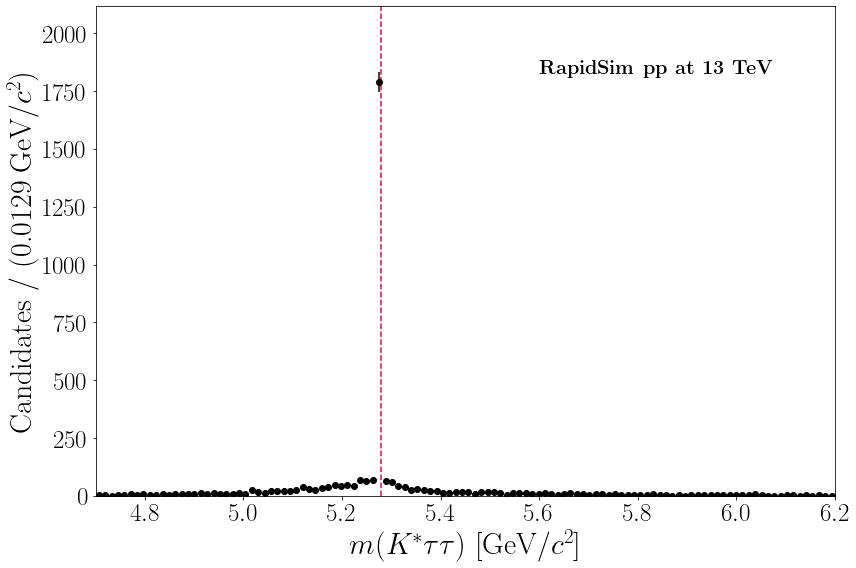

In [112]:
fig, ax = plt.subplots(figsize=(12,8))
n = len(df)
bins = 2*int(np.sqrt(n))
low = 4.7
high = 6.2
bin_w = (high - low)/bins
units = "GeV/$c^2$"

counts, bin_edges = np.histogram(df["B_M_best"], bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color='k')
plt.xlabel(f"$m(K^* \\tau \\tau)$ [{units}]",fontsize=30)
plt.ylabel("Candidates / (%.4f %s)" % (bin_w, units), fontsize=30)
plt.xlim(low,high)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.axvline(lp.B_plus.mass/1000.,color='crimson',linestyle='--')
ymin, ymax = plt.ylim()
plt.ylim(0.,ymax*1.1)
plt.text(high-0.6,0.95*ymax,"\\textbf{RapidSim pp at 13 TeV}",fontsize=20)
#plt.text(high-0.7,0.85*ymax,"\\textit{Perfect momentum/vertex/mass res.}",fontsize=20)
#plt.text(high-0.7,0.75*ymax,f"$\\mu = {mu:.2f}$ {units}, $\sigma = {sigma:.2f}$ {units}",fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig("../plots/M_KstTauTau_reco_best.pdf")